<a href="https://colab.research.google.com/github/NckYang/Baseball-Prediction-Project/blob/main/MLB_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

檢測到 Colab 環境，正在掛載 Google Drive...
Mounted at /content/drive
--- 發現檔案 'statcast_data_2022_2025_full.parquet'，直接讀取 ---
正在對全數據進行時間排序...

開始計算球員累積強弱特徵 (Rolling Window & Platoon)...
  -> 計算打者滾動數據 (Last 100 PA)...

  [Data Trace] Aaron Judge (592450) Rolling Stats Sample:
       game_pk  at_bat_number  batter_avg_roll  batter_ops_roll  \
3882    661333              9         0.250000         0.250000   
4183    661333             24         1.000000         2.000000   
4191    661333             40         0.500000         1.000000   
4034    661333             59         0.333333         0.666667   
4095    661333             74         0.250000         0.500000   
7788    661332              5         0.400000         1.000000   
7824    661332             29         0.333333         0.833333   
7636    661332             46         0.285714         0.714286   
7694    661332             62         0.285714         0.803571   
12065   661316             10         0.250000         0.708333

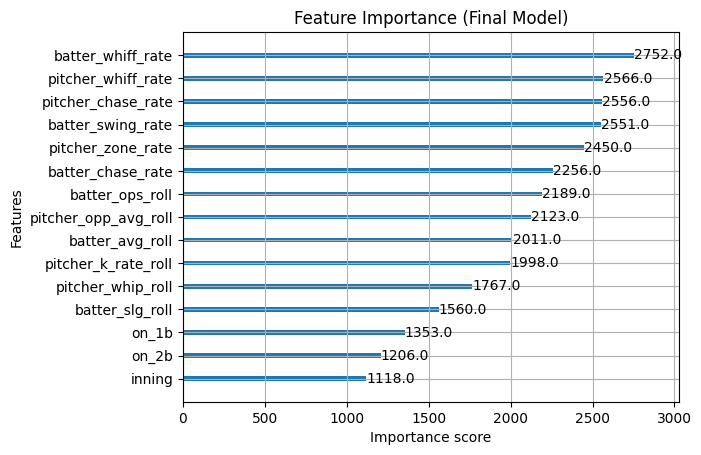

In [ ]:
# -*- coding: utf-8 -*-
"""
Baseball Prediction v35.0 - Improved Macro-Strategy Model
"""

import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, brier_score_loss, roc_auc_score, log_loss
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 嘗試掛載 Google Drive (如果是 Colab 環境)
try:
    from google.colab import drive
    print("檢測到 Colab 環境，正在掛載 Google Drive...")
    drive.mount('/content/drive')
except ImportError:
    print("未檢測到 Colab 環境，跳過 Google Drive 掛載。")

# ========== 2. 輔助函式 ==========

def get_statcast_data(file_path):
    if os.path.exists(file_path):
        print(f"--- 發現檔案 '{os.path.basename(file_path)}'，直接讀取 ---")
        return pd.read_parquet(file_path)
    else:
        print(f"錯誤：找不到指定的數據檔案 '{file_path}'。")
        return None

def add_player_career_stats(df):
    """
    為數據集加入打者與投手的「賽前/打席前」累積數據特徵 (Step A)。
    包含：滾動平均 (Rolling) 打擊率, OPS, 投手被打擊率, K%, 以及左右投打對戰 (Platoon) 特徵。
    """
    print("\n" + "="*80)
    print("開始計算球員累積強弱特徵 (Rolling Window & Platoon)...")

    # 複製一份以避免修改原始資料
    df_stats = df.copy()

    # 1. 確保數據按時間排序
    if df_stats['game_date'].dtype == 'object':
        df_stats['game_date'] = pd.to_datetime(df_stats['game_date'])

    df_stats = df_stats.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'])

    # [Fix] 確保 Key 的類型一致 (全部轉為 int)
    df_stats['game_pk'] = pd.to_numeric(df_stats['game_pk'], errors='coerce').fillna(0).astype(int)
    df_stats['at_bat_number'] = pd.to_numeric(df_stats['at_bat_number'], errors='coerce').fillna(0).astype(int)

    # 2. 定義打擊事件結果
    df_stats['events'] = df_stats['events'].fillna('')

    at_bat_end_events = [
        'single', 'double', 'triple', 'home_run', 'strikeout',
        'walk', 'hit_by_pitch', 'field_out', 'pop_out', 'fly_out',
        'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'field_error'
    ]
    df_stats['is_ab_end'] = df_stats['events'].isin(at_bat_end_events).astype(int)

    # 計算基礎數據 (Base Stats)
    df_stats['is_hit'] = df_stats['events'].isin(['single', 'double', 'triple', 'home_run']).astype(int)
    df_stats['is_ab'] = df_stats['events'].isin(['single', 'double', 'triple', 'home_run', 'strikeout', 'field_out', 'pop_out', 'fly_out', 'grounded_into_double_play']).astype(int)
    df_stats['is_on_base'] = df_stats['events'].isin(['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch']).astype(int)
    df_stats['is_k'] = (df_stats['events'] == 'strikeout').astype(int)
    df_stats['is_bb'] = (df_stats['events'] == 'walk').astype(int)

    # 計算長打數 (Total Bases)
    conditions = [
        (df_stats['events'] == 'single'),
        (df_stats['events'] == 'double'),
        (df_stats['events'] == 'triple'),
        (df_stats['events'] == 'home_run')
    ]
    choices = [1, 2, 3, 4]
    df_stats['total_bases'] = np.select(conditions, choices, default=0)

    # ==========================================
    # 3. 計算打者滾動數據 (Batter Rolling Stats)
    # ==========================================
    print("  -> 計算打者滾動數據 (Last 100 PA)...")

    # [Fix] 使用 groupby().tail(1) 確保抓取到每個打席的最後一球，保證覆蓋率 100%
    # 這比依賴 events 列表更穩健，能避免因事件名稱不匹配導致的數據丟失
    df_ab = df_stats.groupby(['game_pk', 'at_bat_number']).tail(1).copy()

    # 強制排序以確保 Rolling 正確
    df_ab = df_ab.sort_values(by=['game_date', 'game_pk', 'at_bat_number'])

    # 標記這是打席結束 (因為我們選的是 tail(1))
    df_ab['is_pa_end'] = 1

    # 定義滾動窗口大小
    WINDOW_SIZE = 100

    batter_group = df_ab.groupby('batter')

    # Rolling Sums (shift(1) to avoid leakage)
    df_ab['b_roll_ab'] = batter_group['is_ab'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    df_ab['b_roll_h'] = batter_group['is_hit'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    df_ab['b_roll_ob'] = batter_group['is_on_base'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    df_ab['b_roll_tb'] = batter_group['total_bases'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    # 使用 is_pa_end 來計算總打席數
    df_ab['b_roll_pa'] = batter_group['is_pa_end'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())

    # 計算滾動率值
    df_ab['batter_avg_roll'] = df_ab['b_roll_h'] / df_ab['b_roll_ab'].replace(0, 1)
    df_ab['batter_obp_roll'] = df_ab['b_roll_ob'] / df_ab['b_roll_pa'].replace(0, 1)
    df_ab['batter_slg_roll'] = df_ab['b_roll_tb'] / df_ab['b_roll_ab'].replace(0, 1)
    df_ab['batter_ops_roll'] = df_ab['batter_obp_roll'] + df_ab['batter_slg_roll']

    # 填充初期值
    df_ab[['batter_avg_roll', 'batter_obp_roll', 'batter_slg_roll', 'batter_ops_roll']] = df_ab[['batter_avg_roll', 'batter_obp_roll', 'batter_slg_roll', 'batter_ops_roll']].fillna(0.250)

    # 將計算好的 Rolling Stats 映射回原始 df_stats
    rolling_stats_cols = ['batter_avg_roll', 'batter_ops_roll', 'batter_slg_roll']
    df_ab_subset = df_ab[['game_pk', 'at_bat_number'] + rolling_stats_cols]

    # [Fix] 確保 Key 的類型一致
    df_ab_subset['game_pk'] = df_ab_subset['game_pk'].astype(int)
    df_ab_subset['at_bat_number'] = df_ab_subset['at_bat_number'].astype(int)

    # [Fix] 檢查重複鍵值
    dupes = df_ab_subset.duplicated(subset=['game_pk', 'at_bat_number']).sum()
    if dupes > 0:
        print(f"  [CRITICAL] 發現 {dupes} 筆重複的鍵值 (game_pk + at_bat_number)！正在移除重複項...")
        df_ab_subset = df_ab_subset.drop_duplicates(subset=['game_pk', 'at_bat_number'])

    # [Debug] Data Trace: Aaron Judge (592450)
    print("\n  [Data Trace] Aaron Judge (592450) Rolling Stats Sample:")
    judge_trace = df_ab_subset[df_ab['batter'] == 592450].head(10)
    if not judge_trace.empty:
        print(judge_trace)
    else:
        print("  (No data found for Aaron Judge)")
    print("-" * 40)

    # [Debug] Pre-Merge Check
    print(f"  [DEBUG] df_stats shape: {df_stats.shape}")
    print(f"  [DEBUG] df_ab_subset shape: {df_ab_subset.shape}")
    print(f"  [DEBUG] df_stats keys sample: {df_stats[['game_pk', 'at_bat_number']].head().values.tolist()}")
    print(f"  [DEBUG] df_ab_subset keys sample: {df_ab_subset[['game_pk', 'at_bat_number']].head().values.tolist()}")

    df_stats = pd.merge(df_stats, df_ab_subset, on=['game_pk', 'at_bat_number'], how='left')

    # [DEBUG] 檢查 Merge 後的狀況
    nan_count = df_stats['batter_avg_roll'].isnull().sum()
    total_count = len(df_stats)
    print(f"  [DEBUG] Merge 後 batter_avg_roll 缺失數: {nan_count} / {total_count} ({nan_count/total_count:.2%})")

    if nan_count > 0:
        print("  [警告] 仍有數據在 Merge 後缺失。檢查是否為資料末端或鍵值問題。")

    print("  -> 廣播打者數據到同打席所有球...")
    for col in rolling_stats_cols:
        # 由於我們已經 merge 了，且 df_ab_subset 是 tail(1)，
        # 所以只有每打席的最後一球有值，其他球是 NaN。
        # 我們需要用 ffill/bfill 來填補同打席的其他球。
        # 但因為我們是 merge on keys，所以其實每球都應該有值？
        # 不！df_ab_subset 每個 (game_pk, at_bat_number) 只有一行。
        # merge 時，df_stats 中所有相同 (game_pk, at_bat_number) 的行都會匹配到那一行。
        # 所以理論上，所有行都應該有值！不需要 ffill/bfill！
        # 除非... merge 失敗。
        # 所以這裡的 transform 其實是多餘的？
        # 讓我們檢查一下。如果 merge 成功，col 應該全滿。
        pass

    # 填補任何剩餘的 NaN (理論上不應有，除非是初期數據)
    for col in rolling_stats_cols:
        col_mean = df_stats[col].mean()
        if pd.isna(col_mean): col_mean = 0.250
        df_stats[col] = df_stats[col].fillna(col_mean)

    # ==========================================
    # 4. 計算投手滾動數據 (Pitcher Rolling Stats)
    # ==========================================
    print("  -> 計算投手滾動數據 (Last 100 PA)...")

    pitcher_group = df_ab.groupby('pitcher')

    # 使用 is_pa_end
    df_ab['p_roll_pa'] = pitcher_group['is_pa_end'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    df_ab['p_roll_h'] = pitcher_group['is_hit'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    df_ab['p_roll_k'] = pitcher_group['is_k'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())
    df_ab['p_roll_bb'] = pitcher_group['is_bb'].transform(lambda x: x.shift(1).rolling(window=WINDOW_SIZE, min_periods=1).sum())

    # 計算率值
    df_ab['pitcher_opp_avg_roll'] = df_ab['p_roll_h'] / (df_ab['p_roll_pa'] - df_ab['p_roll_bb']).replace(0, 1)
    df_ab['pitcher_k_rate_roll'] = df_ab['p_roll_k'] / df_ab['p_roll_pa'].replace(0, 1)

    est_innings = df_ab['p_roll_pa'] / 4.2
    df_ab['pitcher_whip_roll'] = (df_ab['p_roll_h'] + df_ab['p_roll_bb']) / est_innings.replace(0, 1)

    # 填充
    # 改為使用平均值填充
    for col in ['pitcher_opp_avg_roll', 'pitcher_k_rate_roll', 'pitcher_whip_roll']:
        col_mean = df_ab[col].mean()
        if pd.isna(col_mean): col_mean = 0.250
        df_ab[col] = df_ab[col].fillna(col_mean)

    # Merge 回去
    p_rolling_cols = ['pitcher_opp_avg_roll', 'pitcher_k_rate_roll', 'pitcher_whip_roll']
    df_ab_p_subset = df_ab[['game_pk', 'at_bat_number'] + p_rolling_cols]

    df_stats = pd.merge(df_stats, df_ab_p_subset, on=['game_pk', 'at_bat_number'], how='left')


    # (Removed erroneous encoding block)


    # ==========================================
    # 5. Platoon Splits (左右投打)
    # ==========================================
    print("  -> 處理左右投打特徵...")
    df_stats['is_platoon_advantage'] = np.where(df_stats['stand'] != df_stats['p_throws'], 1, 0)


    # ===========================================
    # 6. Calculate Advanced Behavioral Features (EFFICIENT AT-BAT AGGREGATION)
    # ===========================================
    print("  -> Calculating advanced behavioral features (at-bat level aggregation)...")

    # Step 6.1: Create pitch-level boolean indicators
    # Zone: Statcast zone 1-9 is strike zone
    if 'zone' in df_stats.columns:
        df_stats['is_in_zone'] = df_stats['zone'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9]).astype(int)
    elif 'plate_x' in df_stats.columns and 'plate_z' in df_stats.columns:
        # Approximate strike zone using coordinates
        sz_top = 3.5  # Average top of strike zone
        sz_bot = 1.5  # Average bottom of strike zone

        df_stats['is_in_zone'] = (
            (df_stats['plate_x'].abs() <= 0.85) &
            (df_stats['plate_z'] >= sz_bot) &
            (df_stats['plate_z'] <= sz_top)
        ).fillna(False).astype(int)
    else:
        df_stats['is_in_zone'] = 0

    # Swing: swing-related events
    swing_events = ['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip', 'foul_bunt', 'missed_bunt']
    df_stats['is_swing'] = df_stats['description'].fillna('').isin(swing_events).astype(int)

    # Whiff: swings and misses
    whiff_events = ['swinging_strike', 'swinging_strike_blocked', 'missed_bunt']
    df_stats['is_whiff'] = df_stats['description'].fillna('').isin(whiff_events).astype(int)

    # Chase: swing at pitch outside zone
    df_stats['is_out_of_zone'] = 1 - df_stats['is_in_zone']
    df_stats['is_chase'] = ((df_stats['is_out_of_zone'] & df_stats['is_swing']) > 0).astype(int)

    # Step 6.2: Aggregate to at-bat level (MUCH FASTER than pitch-level rolling)
    print("  -> Aggregating pitch behaviors to at-bat level...")
    ab_behavior = df_stats.groupby(['game_pk', 'at_bat_number', 'batter', 'pitcher'], as_index=False).agg({
        'pitch_number': 'count',     # total_pitches
        'is_swing': 'sum',           # total_swings
        'is_in_zone': 'sum',         # pitches_in_zone
        'is_chase': 'sum',           # total_chases
        'is_whiff': 'sum',           # total_whiffs
        'is_out_of_zone': 'sum'      # pitches_out_of_zone
    })

    ab_behavior.columns = ['game_pk', 'at_bat_number', 'batter', 'pitcher',
                           'total_pitches', 'total_swings', 'pitches_in_zone',
                           'total_chases', 'total_whiffs', 'pitches_out_of_zone']

    # Step 6.3: Calculate rolling stats at at-bat level (50 at-bats window)
    WINDOW_AB = 50
    print("  -> Calculating batter behavioral rolling stats (last 50 at-bats)...")

    batter_ab_group = ab_behavior.sort_values(['batter', 'game_pk', 'at_bat_number']).groupby('batter')

    ab_behavior['b_roll_pitches'] = batter_ab_group['total_pitches'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['b_roll_swings'] = batter_ab_group['total_swings'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['b_roll_chases'] = batter_ab_group['total_chases'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['b_roll_out_zone'] = batter_ab_group['pitches_out_of_zone'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['b_roll_whiffs'] = batter_ab_group['total_whiffs'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )

    # Calculate batter rates
    ab_behavior['batter_swing_rate'] = ab_behavior['b_roll_swings'] / ab_behavior['b_roll_pitches'].replace(0, 1)
    ab_behavior['batter_chase_rate'] = ab_behavior['b_roll_chases'] / ab_behavior['b_roll_out_zone'].replace(0, 1)
    ab_behavior['batter_whiff_rate'] = ab_behavior['b_roll_whiffs'] / ab_behavior['b_roll_swings'].replace(0, 1)

    print("  -> Calculating pitcher behavioral rolling stats (last 50 at-bats)...")

    pitcher_ab_group = ab_behavior.sort_values(['pitcher', 'game_pk', 'at_bat_number']).groupby('pitcher')

    ab_behavior['p_roll_pitches'] = pitcher_ab_group['total_pitches'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['p_roll_in_zone'] = pitcher_ab_group['pitches_in_zone'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['p_roll_swings'] = pitcher_ab_group['total_swings'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['p_roll_whiffs'] = pitcher_ab_group['total_whiffs'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['p_roll_chases'] = pitcher_ab_group['total_chases'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )
    ab_behavior['p_roll_out_zone'] = pitcher_ab_group['pitches_out_of_zone'].transform(
        lambda x: x.shift(1).rolling(window=WINDOW_AB, min_periods=10).sum()
    )

    # Calculate pitcher rates
    ab_behavior['pitcher_zone_rate'] = ab_behavior['p_roll_in_zone'] / ab_behavior['p_roll_pitches'].replace(0, 1)
    ab_behavior['pitcher_whiff_rate'] = ab_behavior['p_roll_whiffs'] / ab_behavior['p_roll_swings'].replace(0, 1)
    ab_behavior['pitcher_chase_rate'] = ab_behavior['p_roll_chases'] / ab_behavior['p_roll_out_zone'].replace(0, 1)

    # Fill missing values with league averages
    ab_behavior['batter_swing_rate'] = ab_behavior['batter_swing_rate'].fillna(0.47)
    ab_behavior['batter_chase_rate'] = ab_behavior['batter_chase_rate'].fillna(0.30)
    ab_behavior['batter_whiff_rate'] = ab_behavior['batter_whiff_rate'].fillna(0.25)
    ab_behavior['pitcher_zone_rate'] = ab_behavior['pitcher_zone_rate'].fillna(0.49)
    ab_behavior['pitcher_whiff_rate'] = ab_behavior['pitcher_whiff_rate'].fillna(0.25)
    ab_behavior['pitcher_chase_rate'] = ab_behavior['pitcher_chase_rate'].fillna(0.30)

    # Step 6.4: Merge back to pitch-level data
    print("  -> Merging behavioral features back to pitch level...")
    behavioral_features = ['batter_swing_rate', 'batter_chase_rate', 'batter_whiff_rate',
                          'pitcher_zone_rate', 'pitcher_whiff_rate', 'pitcher_chase_rate']

    df_stats = df_stats.merge(
        ab_behavior[['game_pk', 'at_bat_number'] + behavioral_features],
        on=['game_pk', 'at_bat_number'],
        how='left'
    )

    # Final fillna for any remaining missing values
    for feat in behavioral_features:
        if feat.startswith('batter'):
            df_stats[feat] = df_stats[feat].fillna(0.47 if 'swing' in feat else 0.30 if 'chase' in feat else 0.25)
        else:
            df_stats[feat] = df_stats[feat].fillna(0.49 if 'zone' in feat else 0.30 if 'chase' in feat else 0.25)

    # ==========================================
    # 7. 清理與回傳
    # ==========================================
    # 選擇要保留的新特徵
    new_features = [
        'batter_avg_roll', 'batter_ops_roll', 'batter_slg_roll',
        'pitcher_opp_avg_roll', 'pitcher_k_rate_roll', 'pitcher_whip_roll',
        'is_platoon_advantage',
        'batter_swing_rate', 'batter_chase_rate', 'batter_whiff_rate',
        'pitcher_zone_rate', 'pitcher_whiff_rate', 'pitcher_chase_rate'
    ]

    # 填補缺失值 (以防萬一)
    # 這裡不再強制填 0，而是再次檢查是否還有 NaN，有的話填平均值
    for col in new_features:
        if df_stats[col].isnull().sum() > 0:
             col_mean = df_stats[col].mean()
             if pd.isna(col_mean): col_mean = 0
             df_stats[col] = df_stats[col].fillna(col_mean)

    # 確保每個打席內的所有球都有相同的「賽前」特徵
    # 因為我們是按球排序計算的，同一個打席內的球應該共享該打席開始前的狀態
    # 但上面的 rolling 是逐球 shift，所以每球會微變。這其實更精確（反映了上一球的結果），
    # 但為了邏輯一致性，通常我們會希望預測第一球時和預測第三球時，對打者能力的評估不要變動太大。
    # 不過在這裡，逐球更新其實是可以接受的，甚至更好。

    # 廣播進階特徵到同打席
    adv_features = ['batter_swing_rate', 'batter_chase_rate', 'batter_whiff_rate', 'pitcher_zone_rate', 'pitcher_whiff_rate', 'pitcher_chase_rate']
    print("  -> 廣播進階特徵到同打席所有球...")
    for col in adv_features:
        df_stats[col] = df_stats.groupby(['game_pk', 'at_bat_number'])[col].transform(lambda x: x.ffill().bfill())
        # 再次填補缺失值 (以防萬一)
        if 'batter' in col:
             df_stats[col] = df_stats[col].fillna(0.30)
        else:
             df_stats[col] = df_stats[col].fillna(0.30)

    print("球員累積特徵計算完成！")
    return df_stats

def simplify_pitch_type(pitch):
    if pitch in ['FF', 'SI', 'FC', 'FT']: return 'FB_Fastball'
    elif pitch in ['SL', 'CU', 'ST', 'KC']: return 'BB_Breaking'
    elif pitch in ['CH', 'FS', 'FO']: return 'OS_Offspeed'
    return 'Other'

from sklearn.calibration import CalibratedClassifierCV

# ========== 3. v35 核心訓練與驗證模組 ==========

def train_at_bat_outcome_model_v35(df_train):
    """【v35 宏觀策略模型】訓練「打席最終結果」模型，專注於機率校準 (Probability Calibration)。 """
    print("\n" + "="*80)
    print(f"開始訓練【v35 宏觀策略模型 - Probability Optimized】...")
    model_data = df_train.copy()

    # 1. 建立預測目標：at_bat_outcome
    at_bat_ending_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_out', 'strikeout', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'fielders_choice_out', 'field_error', 'double_play']
    model_data['is_at_bat_end'] = model_data['events'].isin(at_bat_ending_events)
    model_data['final_event'] = model_data.loc[model_data['is_at_bat_end']].groupby(['game_pk', 'at_bat_number'])['events'].transform('last')
    model_data['final_event'] = model_data.groupby(['game_pk', 'at_bat_number'])['final_event'].fillna(method='ffill').fillna(method='bfill')
    on_base_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_error']
    model_data['at_bat_outcome'] = model_data['final_event'].isin(on_base_events).astype(int)

    # 2. 建立情境特徵
    for col in ['balls', 'strikes', 'outs_when_up', 'inning']:
        model_data[col] = model_data[col].fillna(0).astype(int)
    for col in ['on_1b', 'on_2b', 'on_3b']:
        model_data[col] = model_data[col].fillna(0).astype(int)
    for col in ['stand', 'p_throws']:
        model_data[col] = model_data[col].fillna('Unknown')

    model_data = model_data.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
    model_data['prev_pitch_type'] = model_data.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1).fillna('First_Pitch')

    key_outcomes = ['swinging_strike', 'foul', 'ball', 'called_strike', 'hit_into_play']
    model_data['pitch_outcome'] = model_data['description'].fillna('other').apply(lambda x: x if x in key_outcomes else 'other')
    model_data['prev_pitch_outcome'] = model_data.groupby(['game_pk', 'at_bat_number'])['pitch_outcome'].shift(1).fillna('First_Pitch')

    # 4. 最終數據準備 (使用新特徵)
    CAT_FEATURES = ['stand', 'p_throws', 'prev_pitch_type', 'prev_pitch_outcome']
    NUM_FEATURES = [
        'balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b', 'pitch_number',
        'batter_avg_roll', 'batter_ops_roll', 'batter_slg_roll',
        'pitcher_opp_avg_roll', 'pitcher_k_rate_roll', 'pitcher_whip_roll',
        'is_platoon_advantage',
        'batter_swing_rate', 'batter_chase_rate', 'batter_whiff_rate',
        'pitcher_zone_rate', 'pitcher_whiff_rate', 'pitcher_chase_rate'
    ]

    model_data.dropna(subset=['at_bat_outcome'], inplace=True)

    encoders = {}
    for col in CAT_FEATURES:
        le = LabelEncoder()
        model_data[col] = le.fit_transform(model_data[col].astype(str))
        encoders[col] = le

    ALL_FEATURES = NUM_FEATURES + CAT_FEATURES
    X = model_data[ALL_FEATURES]
    y = model_data['at_bat_outcome']

    if len(X) < 100:
        print("警告: v35 宏觀模型數據量不足")
        return None, None, None, None

    # 5. 訓練模型
    # 移除 scale_pos_weight 以避免機率失真
    # 暫時移除 CalibratedClassifierCV 以觀察原始模型的區分能力

    base_model = xgb.XGBClassifier(
        random_state=42,
        eval_metric=['logloss', 'auc'], # 監控 AUC 和 LogLoss
        objective='binary:logistic',
        use_label_encoder=False,
        n_estimators=300, # 增加樹的數量
        max_depth=7, # 增加深度以捕捉更多特徵交互
        learning_rate=0.03, # 稍微降低學習率以配合更多的樹
        min_child_weight=3, # 避免過度擬合噪音
        # scale_pos_weight=1
    )

    # 使用 Isotonic Regression 進行校準 (需要足夠數據，否則用 sigmoid)
    # cv=3 表示內部會做 3-fold CV 來訓練校準器
    # calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)

    # ========== 診斷區塊 (Diagnostics) ==========
    print("\n" + "="*80)
    print("### 深度診斷模式 (Deep Dive Diagnostics) ###")
    print("="*80)

    # 1. 檢查特徵變異數
    print("1. 特徵統計摘要 (前 5 筆):")
    print(X.head())
    print("\n特徵統計描述:")
    print(X.describe().transpose()[['mean', 'std', 'min', '50%', 'max']])

    # 2. 過擬合測試 (Sanity Check)
    print("\n2. 執行過擬合測試 (Overfit Sanity Check)...")
    print("   -> 取前 1000 筆數據，使用高複雜度模型嘗試硬記...")

    X_sample = X.head(1000)
    y_sample = y.head(1000)

    overfit_model = xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        objective='binary:logistic',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=20, # 極深樹
        learning_rate=0.3, # 高學習率
        min_child_weight=1
    )

    overfit_model.fit(X_sample, y_sample)
    y_sample_pred = overfit_model.predict(X_sample)
    sample_acc = accuracy_score(y_sample, y_sample_pred)

    print(f"   -> 過擬合測試準確率: {sample_acc:.4f}")
    if sample_acc < 0.95:
        print("   [!!! 嚴重警告 !!!] 模型無法過擬合小樣本，表示特徵與結果可能無關，或代碼有嚴重 Bug！")
    else:
        print("   [OK] 模型具備學習能力，特徵包含有效資訊。")

    print("="*80 + "\n")

    print("  -> 訓練原始 XGBoost 模型 (無校準)...")
    base_model.fit(X, y)

    print(f"【v35 宏觀策略模型】訓練完成 (Raw XGBoost)！")

    # 3. 輸出特徵重要性
    print("\n[特徵重要性 Top 20]")
    feature_imp = pd.DataFrame({'Feature': ALL_FEATURES, 'Importance': base_model.feature_importances_})
    feature_imp = feature_imp.sort_values('Importance', ascending=False).head(20)
    print(feature_imp)
    print("-" * 40)

    # ========== 評估訓練集表現 ==========
    print("\n" + "="*80)
    print("### 訓練集表現評估 (Raw XGBoost) ###")
    print("="*80)

    y_train_pred_proba = base_model.predict_proba(X)[:, 1]
    y_train_pred_class = (y_train_pred_proba >= 0.5).astype(int)

    train_loss = log_loss(y, y_train_pred_proba)
    train_brier = brier_score_loss(y, y_train_pred_proba)
    train_roc_auc = roc_auc_score(y, y_train_pred_proba)
    train_accuracy = accuracy_score(y, y_train_pred_class)
    train_f1 = f1_score(y, y_train_pred_class, pos_label=1, zero_division=0)

    print(f"  → Brier 分數 (機率誤差): {train_brier:.4f}")
    print(f"  → Log Loss (對數損失): {train_loss:.4f}")
    print(f"  → ROC-AUC Score: {train_roc_auc:.4f}")
    print(f"  → 準確率 (Accuracy at 0.50): {train_accuracy:.4f}")
    print(f"  → 準確率 (Accuracy at 0.50): {train_accuracy:.4f}")
    print(f"  → 上壘類別 F1-Score (at 0.50): {train_f1:.4f}")

    # [Debug] 訓練集相關性檢查
    print("\n[Debug] 訓練集關鍵特徵相關性檢查 (Training Correlation Check):")
    train_feat_corr = X['batter_avg_roll'].corr(y)
    print(f"  -> batter_avg_roll vs Target Corr: {train_feat_corr:.4f}")

    print(f"\n  詳細分類報告 (at 0.50):")
    print(classification_report(y, y_train_pred_class, target_names=['At-Bat Out', 'On Base'], zero_division=0, digits=4))

    # 訓練集機率分佈統計
    print(f"\n  訓練集機率分佈統計:")
    print(pd.Series(y_train_pred_proba).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
    print("="*80)

    return base_model, encoders, ALL_FEATURES, 0.5 # 回傳預設閾值 0.5

# ========== 4. v35 核心應用函式 ==========

def evaluate_model_performance(model, X, y, dataset_name="Dataset"):
    """評估模型在指定數據集上的表現"""
    if len(y) == 0:
        print(f"  [警告] {dataset_name} 數據為空，無法評估。")
        return

    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    loss = log_loss(y, y_pred_proba)
    brier = brier_score_loss(y, y_pred_proba)
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class, pos_label=1, zero_division=0)

    print(f"\n  --- {dataset_name} 評估報告 ---")
    print(f"  樣本數: {len(y)}")
    print(f"  -> Brier 分數 (機率誤差): {brier:.4f}")
    print(f"  -> Log Loss (對數損失): {loss:.4f}")
    print(f"  -> ROC-AUC Score: {roc_auc:.4f}")
    print(f"  -> 準確率 (Accuracy at 0.50): {accuracy:.4f}")
    print(f"  -> F1-Score (at 0.50): {f1:.4f}")
    print(f"  詳細分類報告:")
    print(classification_report(y, y_pred_class, target_names=['At-Bat Out', 'On Base'], zero_division=0, digits=4))

def run_systematic_validation_v35(full_data):
    """
    【v35 核心】執行系統性回測：
    1. (調參階段) Train -> Val 驗證參數
    2. (最終階段) Train + Val -> 重新訓練模型
    3. (測試階段) Test -> 最終評估
    """

    print("\n" + "#"*30)
    print("### 階段一：準備數據集 (Train/Val/Test) ###")
    print("#"*30)

    # 1. 篩選數據 (與原版相同)
    is_3B1S = (full_data['balls'] == 3) & (full_data['strikes'] == 1)
    is_2S_AllB = (full_data['strikes'] == 2)
    full_data['events'] = full_data['events'].astype(str)
    full_data['description'] = full_data['description'].astype(str)

    target_pitches = full_data[is_3B1S | is_2S_AllB].copy()
    if len(target_pitches) < 100:
        print(f"錯誤：數據不足。")
        return

    # 2. 時間分割 (70% Train, 15% Val, 15% Test)
    if full_data['game_date'].dtype == 'object':
        full_data['game_date'] = pd.to_datetime(full_data['game_date'])
    full_data = full_data.sort_values(by=['game_date', 'game_pk', 'at_bat_number'])

    split_date_1 = full_data['game_date'].quantile(0.70, interpolation='lower')
    split_date_2 = full_data['game_date'].quantile(0.85, interpolation='lower')

    df_train = full_data[full_data['game_date'] < split_date_1].copy()
    df_val = full_data[(full_data['game_date'] >= split_date_1) & (full_data['game_date'] < split_date_2)].copy()
    df_test = full_data[full_data['game_date'] >= split_date_2].copy()

    print(f"數據分割:")
    print(f"  Train Set (調參用): < {split_date_1.date()} (Count: {len(df_train)})")
    print(f"  Val Set   (調參用): {split_date_1.date()} ~ {split_date_2.date()} (Count: {len(df_val)})")
    print(f"  Test Set  (最終考): >= {split_date_2.date()} (Count: {len(df_test)})")

    # 定義輔助函式 (移到前面以便重複使用)
    def prepare_eval_data(df, encoders, features):
        data = df.copy()
        # ... (這裡保持原有的資料處理邏輯，為節省篇幅省略重複代碼，請保留原有的 prepare_eval_data 內容) ...
        # 4a. 建立預測目標
        at_bat_ending_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_out', 'strikeout', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'fielders_choice_out', 'field_error', 'double_play']
        data['is_at_bat_end'] = data['events'].isin(at_bat_ending_events)
        data['final_event'] = data.loc[data['is_at_bat_end']].groupby(['game_pk', 'at_bat_number'])['events'].transform('last')
        data['final_event'] = data.groupby(['game_pk', 'at_bat_number'])['final_event'].fillna(method='ffill').fillna(method='bfill')
        on_base_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_error']
        data['at_bat_outcome'] = data['final_event'].isin(on_base_events).astype(int)

        # 4b. 建立基本情境特徵
        for col in ['balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b']:
            data[col] = data[col].fillna(0).astype(int)

        data = data.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
        data['prev_pitch_type'] = data.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1).fillna('First_Pitch')

        key_outcomes = ['swinging_strike', 'foul', 'ball', 'called_strike', 'hit_into_play']
        data['pitch_outcome'] = data['description'].fillna('other').apply(lambda x: x if x in key_outcomes else 'other')
        data['prev_pitch_outcome'] = data.groupby(['game_pk', 'at_bat_number'])['pitch_outcome'].shift(1).fillna('First_Pitch')

        # 4c. 處理類別特徵
        CAT_FEATURES = ['stand', 'p_throws', 'prev_pitch_type', 'prev_pitch_outcome']
        for col in CAT_FEATURES:
            data[col] = data[col].fillna('Unknown')
            # 處理 LabelEncoder
            if col in encoders:
                le = encoders[col]
                data[col] = data[col].map(lambda s: s if s in le.classes_ else 'Unknown')
                le_classes = le.classes_.tolist()
                if 'Unknown' not in le_classes:
                     # 如果 Unknown 不在訓練過的 encoder 裡，通常替換成 mode 或 0
                    data[col] = data[col].replace('Unknown', le_classes[0])
                data[col] = le.transform(data[col])
            else:
                 # 若無 encoder (理論不應發生)，設為 0
                 data[col] = 0

        # 4d. 準備最終的 X 和 y
        data.dropna(subset=['at_bat_outcome'], inplace=True)
        # 確保特徵順序一致
        X = data.reindex(columns=features, fill_value=0)
        y = data['at_bat_outcome']
        return X, y

    # =========================================================
    # 步驟 1: 調參階段 (Validation Phase)
    # =========================================================
    print("\n" + "#"*30)
    print("### 步驟 1: 調參階段 (Train Only -> Validate on Val) ###")
    print("說明：此階段用於觀察超參數是否過擬合，並確認模型方向正確。")
    print("#"*30)

    # 使用 70% 數據訓練
    model_v1, encoders_v1, features_v1, _ = train_at_bat_outcome_model_v35(df_train)

    # 使用 15% 數據驗證
    print("\n[調參參考] Validation Set 表現:")
    X_val, y_val = prepare_eval_data(df_val, encoders_v1, features_v1)
    evaluate_model_performance(model_v1, X_val, y_val, "Validation Set (Tuning)")

    # =========================================================
    # 步驟 2: 重新訓練階段 (Refitting Phase)
    # =========================================================
    print("\n" + "#"*30)
    print("### 步驟 2: 最終模型訓練 (Train + Val Set) ###")
    print("說明：依照教授建議，將 Validation Set 併入訓練，以最大化數據量。")
    print("#"*30)

    # 合併 Train 與 Val (70% + 15% = 85%)
    df_train_val = pd.concat([df_train, df_val])
    print(f"  -> 合併後訓練集大小: {len(df_train_val)} (Train: {len(df_train)} + Val: {len(df_val)})")

    # 重新訓練模型 (使用相同的超參數邏輯)
    # 注意：這裡會產生新的 encoders，所以 Test set 必須用這組新的 encoders 來轉換
    final_model, final_encoders, final_features, _ = train_at_bat_outcome_model_v35(df_train_val)

    # =========================================================
    # 步驟 3: 最終測試階段 (Testing Phase)
    # =========================================================
    print("\n" + "#"*30)
    print("### 步驟 3: 最終測試 (Test Set) ###")
    print("說明：這是模型完全沒看過的數據，代表最終上線的預期表現。")
    print("#"*30)

    # 使用新的 encoders 準備 Test 數據
    X_test, y_test = prepare_eval_data(df_test, final_encoders, final_features)

    # 評估最終表現
    evaluate_model_performance(final_model, X_test, y_test, "Test Set (Final Result)")

    # 針對特定情境 (3B1S, 2S) 在 Test Set 上的表現
    print("\n" + "="*80)
    print("### Test Set 特定情境分析 (Final Model) ###")
    print("="*80)

    is_3B1S_test = (X_test['balls'] == 3) & (X_test['strikes'] == 1)
    is_2S_AllB_test = (X_test['strikes'] == 2)

    for context_name, context_filter in [('3B1S', is_3B1S_test), ('2S_AllB', is_2S_AllB_test)]:
        print(f"\n--- Test Set 情境: {context_name} ---")
        X_ctx = X_test[context_filter]
        y_ctx = y_test[context_filter]
        evaluate_model_performance(final_model, X_ctx, y_ctx, f"Test Set ({context_name})")

    # 繪製特徵重要性
    try:
        xgb.plot_importance(final_model, importance_type='weight', max_num_features=15, title='Feature Importance (Final Model)')
        plt.show()
    except Exception as e:
        print(f"  -> 無法繪製特徵重要性: {e}")



if __name__ == "__main__":
    # 使用當前目錄下的檔案
    full_data_path = "statcast_data_2022_2025_full.parquet"

    # 如果是 Colab，嘗試從 Drive 讀取 (作為備案)
    if not os.path.exists(full_data_path):
        colab_path = '/content/drive/MyDrive/MLB_Statcast_Data/statcast_data_2022_2025_full.parquet'
        if os.path.exists(colab_path):
            full_data_path = colab_path

    full_data = get_statcast_data(full_data_path)

    if full_data is not None:
        # [Fix] 全域強制排序，確保時間軸正確
        print("正在對全數據進行時間排序...")
        if full_data['game_date'].dtype == 'object':
            full_data['game_date'] = pd.to_datetime(full_data['game_date'])
        full_data = full_data.sort_values(by=['game_date', 'game_pk', 'at_bat_number'])

        full_data = add_player_career_stats(full_data)
        run_systematic_validation_v35(full_data=full_data)
